In [1]:
#Python Packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import StandardScaler

In [2]:
#load dataset
directory = input('Enter directory to the COVID-19 Dataset: ')
file = '{0}owid-covid-data.csv'.format(directory)
covidData = pd.read_csv(file)
covidData = covidData[['location', 'date', 'new_cases', 'new_deaths']]
covidData.set_index(['location'], inplace = True)
covidData['date'] = pd.to_datetime(covidData['date'])

#the United States will be the country of focus
covid_data = covidData.loc['United States']
covid_data.reset_index(inplace = True)

Enter directory to the COVID-19 Dataset: /Users/michaelonuoha/Downloads/


In [3]:
#split dataset into training (80%) and testing (20%); we will be analyzing the daily cases
train = int(len(covid_data)*0.8)
train_data = np.array(covid_data.iloc[0:train,2]).reshape((-1,1))
test_data = np.array(covid_data.iloc[train:,2]).reshape((-1,1))

#scale training and test data
sc = StandardScaler()
train_data = sc.fit_transform(train_data)
test_data_scale = sc.fit_transform(test_data)

In [4]:
#re-arrange training and test data so that the features will represent the dates; we will use 30 features
features = 30
X_train = []
y_train = []
for i in range(features, len(train_data)):
    X_train.append(train_data[i - features:i])
    y_train.append(train_data[i])
    
X_train = np.array(X_train)
y_train = np.array(y_train)

test_data2 = pd.concat([pd.DataFrame(train_data[-features:]), pd.DataFrame(test_data_scale)], axis = 0)
test_data2 = test_data2.values
X_test = []
val_Y = []
for i in range(features, len(test_data2)):
    X_test.append(test_data2[i - features:i])
    val_Y.append(test_data2[i])
    
X_test = np.array(X_test)
val_Y = np.array(val_Y)

In [5]:
#fit the LSTM model
covid_lstm = Sequential()
covid_lstm.add(LSTM(units = 10, activation = 'relu', input_shape = (features, 1)))
covid_lstm.add(Dense(1))
covid_lstm.compile(optimizer = 'adam', loss = 'mse')
covid_lstm_model = covid_lstm.fit(X_train, y_train, epochs = 100, validation_data = (X_test, val_Y))

Epoch 1/100
32/32 [==============================] - 3s 23ms/step - loss: 0.9104 - val_loss: 1.0086
Epoch 2/100
32/32 [==============================] - 0s 12ms/step - loss: 0.4942 - val_loss: 1.0151
Epoch 3/100
32/32 [==============================] - 0s 13ms/step - loss: 0.4245 - val_loss: 1.0193
Epoch 4/100
32/32 [==============================] - 0s 13ms/step - loss: 0.3946 - val_loss: 1.0213
Epoch 5/100
32/32 [==============================] - 1s 19ms/step - loss: 0.3628 - val_loss: 1.0261
Epoch 6/100
32/32 [==============================] - 0s 12ms/step - loss: 0.3339 - val_loss: 1.0315
Epoch 7/100
32/32 [==============================] - 1s 20ms/step - loss: 0.3194 - val_loss: 1.0356
Epoch 8/100
32/32 [==============================] - 0s 12ms/step - loss: 0.2965 - val_loss: 1.0385
Epoch 9/100
32/32 [==============================] - 0s 12ms/step - loss: 0.2779 - val_loss: 1.0405
Epoch 10/100
32/32 [==============================] - 0s 12ms/step - loss: 0.2690 - val_loss: 1.0461

32/32 [==============================] - 0s 13ms/step - loss: 0.1076 - val_loss: 1.1074
Epoch 83/100
32/32 [==============================] - 0s 11ms/step - loss: 0.0898 - val_loss: 1.0903
Epoch 84/100
32/32 [==============================] - 0s 12ms/step - loss: 0.0874 - val_loss: 1.1034
Epoch 85/100
32/32 [==============================] - 0s 12ms/step - loss: 0.0833 - val_loss: 1.0929
Epoch 86/100
32/32 [==============================] - 0s 14ms/step - loss: 0.0857 - val_loss: 1.1026
Epoch 87/100
32/32 [==============================] - 0s 11ms/step - loss: 0.0852 - val_loss: 1.0875
Epoch 88/100
32/32 [==============================] - 0s 13ms/step - loss: 0.0839 - val_loss: 1.0900
Epoch 89/100
32/32 [==============================] - 0s 13ms/step - loss: 0.0812 - val_loss: 1.0966
Epoch 90/100
32/32 [==============================] - 0s 12ms/step - loss: 0.0806 - val_loss: 1.0948
Epoch 91/100
32/32 [==============================] - 0s 13ms/step - loss: 0.0872 - val_loss: 1.0903
Epo

In [6]:
#test the LSTM model
y_hat = covid_lstm.predict(X_test)
y_hat = sc.inverse_transform(y_hat)
y_hat[y_hat < 0] = 0 
rmse_lstm = (sum((test_data - y_hat)**2) / len(test_data))**(1/2)
rmse_lstm[0]

9/9 [==============================] - 0s 4ms/step


92015.73648400237

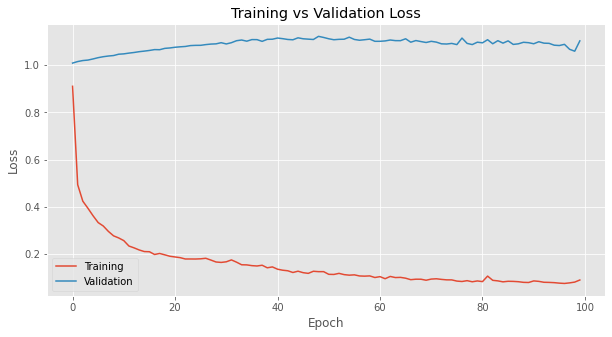

In [7]:
plt.rcParams['figure.figsize'] = [10, 5]
plt.style.use('ggplot')
plt.plot(covid_lstm_model.history['loss'])
plt.plot(covid_lstm_model.history['val_loss'])
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training', 'Validation']);

In [8]:
results = pd.DataFrame(covid_data.iloc[train:,1:3])
results.reset_index(inplace = True)
results = pd.concat([pd.DataFrame(results.date), pd.DataFrame(results.new_cases), pd.DataFrame(y_hat)], axis = 1)
results.rename(columns = {'new_cases':'actual_cases', 0:'predicted_cases'}, inplace=True)
results

,date,actual_cases,predicted_cases
0,2022-11-14,0.0,0.0
1,2022-11-15,0.0,0.0
2,2022-11-16,0.0,0.0
3,2022-11-17,0.0,0.0
4,2022-11-18,274984.0,0.0
...,...,...,...
257,2023-07-29,0.0,0.0
258,2023-07-30,0.0,0.0
259,2023-07-31,0.0,0.0
260,2023-08-01,0.0,0.0


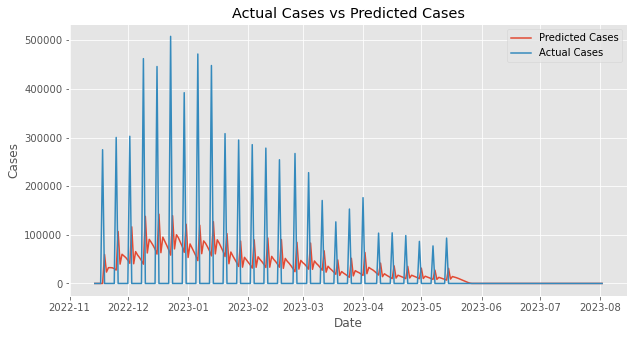

In [9]:
plt.plot(results.date, results.predicted_cases)
plt.plot(results.date, results.actual_cases);
plt.title('Actual Cases vs Predicted Cases')
plt.xlabel('Date')
plt.ylabel('Cases')
plt.legend(['Predicted Cases', 'Actual Cases']);